In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

1. Load the data file using pandas. 

In [2]:
my_data = pd.read_csv('googleplaystore.csv')

In [3]:
my_data.shape

(10841, 13)

2. Check for null values in the data. Get the number of null values for each column.

In [4]:
my_data.isna().any()

App               False
Category          False
Rating             True
Reviews           False
Size              False
Installs          False
Type               True
Price             False
Content Rating     True
Genres            False
Last Updated      False
Current Ver        True
Android Ver        True
dtype: bool

In [5]:
my_data.isna().sum(axis=0)

App                  0
Category             0
Rating            1474
Reviews              0
Size                 0
Installs             0
Type                 1
Price                0
Content Rating       1
Genres               0
Last Updated         0
Current Ver          8
Android Ver          3
dtype: int64

3. Drop records with nulls in any of the columns. 

In [6]:
my_data.dropna(axis=0, inplace=True)

In [7]:
my_data.dtypes

App                object
Category           object
Rating            float64
Reviews            object
Size               object
Installs           object
Type               object
Price              object
Content Rating     object
Genres             object
Last Updated       object
Current Ver        object
Android Ver        object
dtype: object

4. Variables seem to have incorrect type and inconsistent formatting. You need to fix them: 

   1. Size column has sizes in Kb as well as Mb. To analyze, you’ll need to convert these to numeric.

       1. Extract the numeric value from the column

       2. Multiply the value by 1,000, if size is mentioned in Mb

In [8]:
def convert_to_int(value):
    digits = re.findall('(\d+)', value)
    
    result = 0 # default value in case size is NaN
    
    if len(digits) > 0:
        result = int(digits[0])
        
    return result

In [9]:
def convert_to_kb(size):
    new_size = convert_to_int(size)
        
    if 'M' in size:
        new_size = new_size * 1000

    return new_size

In [10]:
my_data['New_Size'] = my_data['Size'].apply(convert_to_kb)

    B. Reviews is a numeric field that is loaded as a string field. Convert it to numeric (int/float).

In [11]:
my_data['Reviews'] = pd.to_numeric(my_data['Reviews'])

    C. Installs field is currently stored as string and has values like 1,000,000+. 

In [12]:
def cleanup_installs(installs):
    installs = installs.replace(',','')
    return convert_to_int(installs)

In [13]:
my_data['New_installs'] = my_data['Installs'].apply(cleanup_installs)

    D. Price field is a string and has $ symbol. Remove ‘$’ sign, and convert it to numeric.

In [14]:
def cleanup_price(price):
    if price == 'Everyone':
        price = '0'
    
    new_price = price.replace('$','')
    return float(new_price)

In [15]:
my_data['New_Price'] = my_data['Price'].apply(cleanup_price)

5. Sanity checks

      5.1. Average rating should be between 1 and 5 as only these values are allowed on the play store. Drop the rows that have a value outside this range.

In [16]:
incorrect_ratings = my_data['Rating'] > 5
my_data.drop(my_data[incorrect_ratings].index, axis=0, inplace = True)

    5.2. Reviews should not be more than installs as only those who installed can review the app. If there are any such records, drop them.

In [17]:
incorrect_reviews = my_data['Reviews'] > my_data['New_installs']
my_data.drop(my_data[incorrect_reviews].index,axis=0, inplace = True)

    5.3. For free apps (type = “Free”), the price should not be >0. Drop any such rows.

In [18]:
incorrect_price = (my_data['Type'] == 'Free') & (my_data['New_Price'] > 0)
my_data.drop(my_data[incorrect_price].index, axis=0, inplace = True)

5. Performing univariate analysis: 

    - Boxplot for Price

Are there any outliers? Think about the price of usual apps on Play Store.

From the BoxPlot we can definitely see that the Prices above 50$ are obvious outliers.


Text(0, 0.5, '')

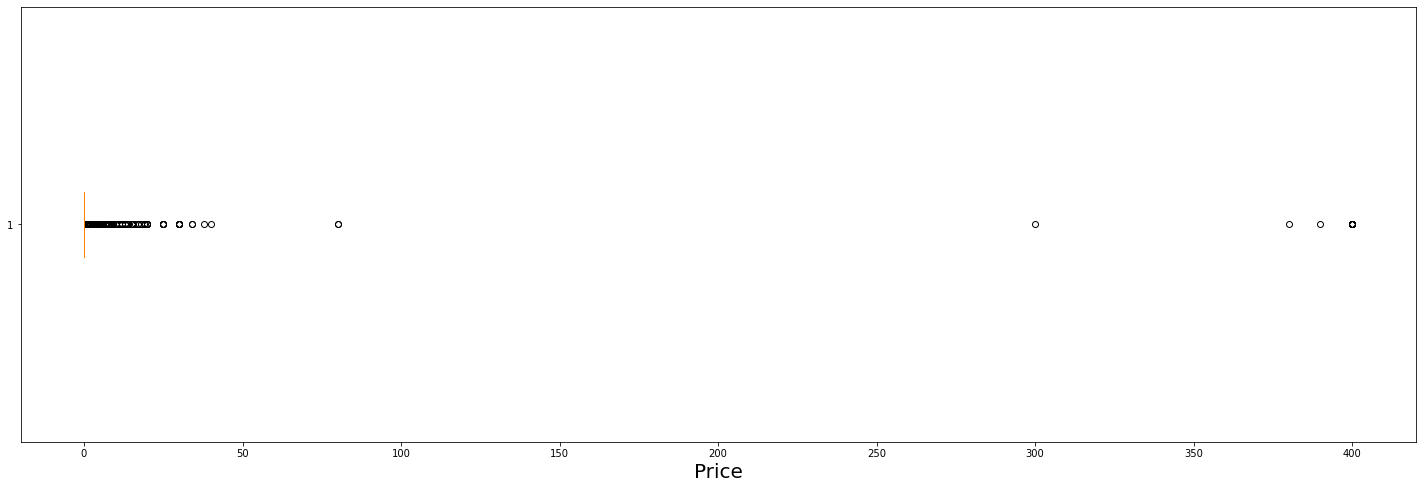

In [19]:
plt.figure(figsize = [25,8])
plt.boxplot(my_data.New_Price, vert=False)
plt.xlabel("Price",fontsize=20)
plt.ylabel("",fontsize=20)

       - Boxplot for Reviews

Are there any apps with very high number of reviews? Do the values seem right?

Some apps have very high number of reviews and are outliers

Text(0, 0.5, '')

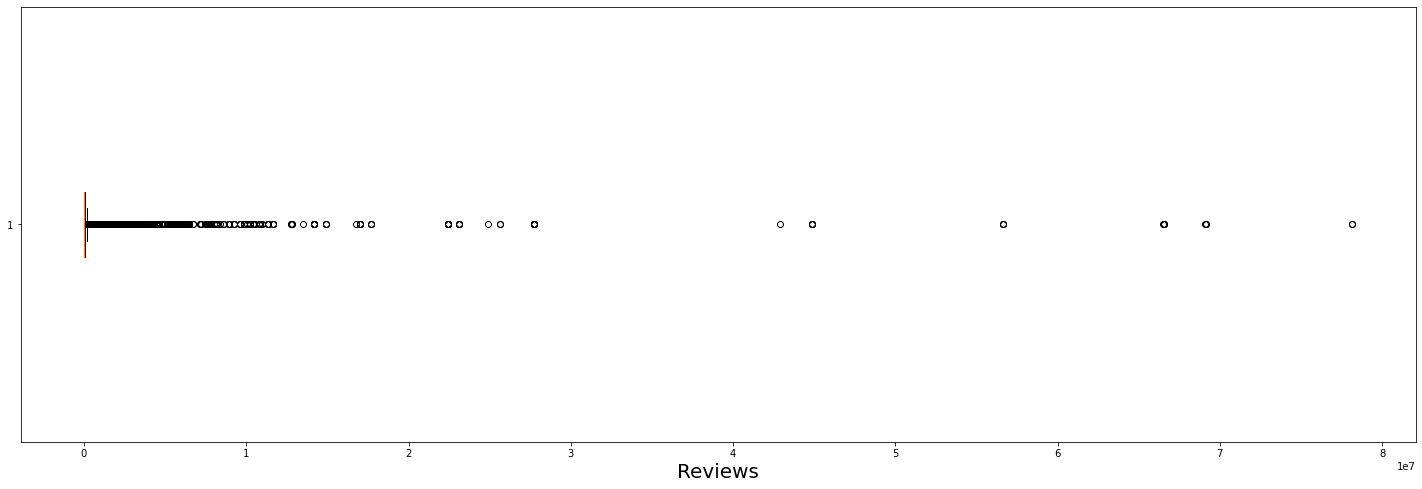

In [20]:
plt.figure(figsize = [25,8])
plt.boxplot(my_data.Reviews,vert=False)
plt.xlabel("Reviews",fontsize=20)
plt.ylabel("",fontsize=20)

          - Histogram for Rating

How are the ratings distributed? Is it more toward higher ratings?

Majority of the apps have higher ratings (most between 4.0 to 5)

Text(0, 0.5, 'Number of Apps')

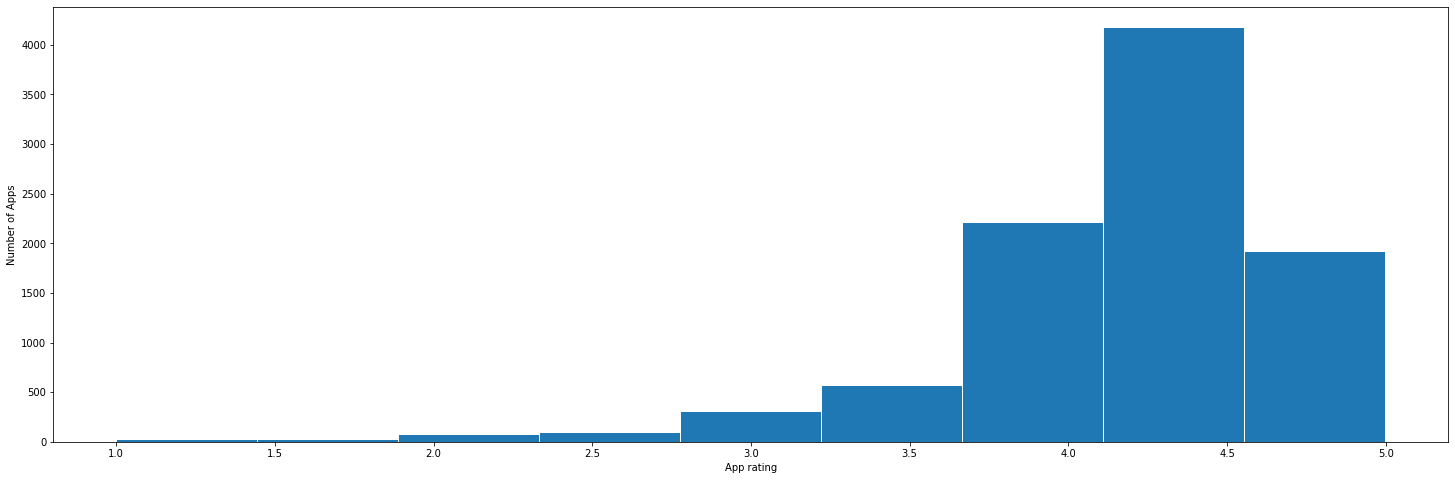

In [21]:
plt.figure(figsize = [25,8])
my_data['Rating'].plot.hist(bins=9,rwidth=0.99)
plt.xlabel('App rating')
plt.ylabel('Number of Apps')


       - Histogram for Size

Note down your observations for the plots made above. Which of these seem to have outliers?

Most apps' size are below 20,000.

Text(0, 0.5, 'Number of App')

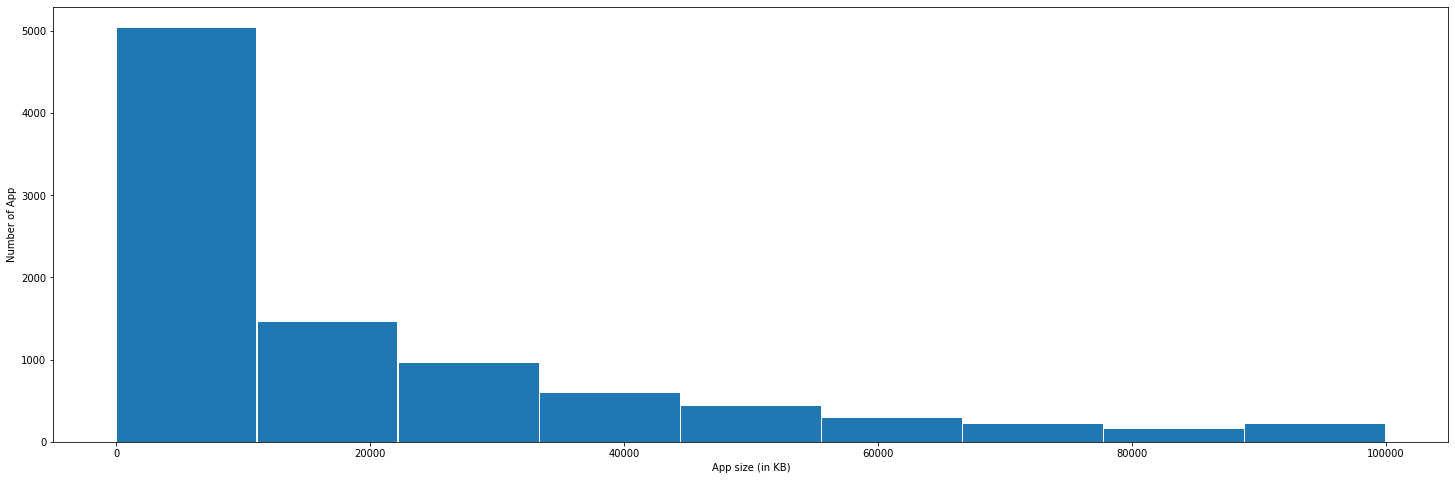

In [22]:
plt.figure(figsize = [25,8])
my_data['New_Size'].plot.hist(bins=9,rwidth=0.99)
plt.xlabel('App size (in KB)')
plt.ylabel('Number of App')

6. Outlier treatment

    6.1  Price
    From the box plot, it seems like there are some apps with very high price. A price of $200 for an application on the Play Store is very high and suspicious!
       - Check out the records with very high price
      Is 200 indeed a high price?   
      
      It seems that price between 0 and 50. We can assume that price above $50 is outlier.
       - Drop these as most seem to be junk apps


In [23]:
my_data.drop(my_data[my_data.New_Price>200].index,axis=0,inplace=True)

     6.2. Reviews: Very few apps have very high number of reviews. These are all star apps that don’t help with the analysis and, in fact, will skew it. Drop records having more than 2 million reviews.

In [24]:
my_data.drop(my_data[my_data.Reviews>2000000].index,axis=0,inplace=True)

      6.3. Installs:  There seems to be some outliers in this field too. Apps having very high number of installs should be dropped from the analysis.
    - Find out the different percentiles – 10, 25, 50, 70, 90, 95, 99


In [25]:
my_data['New_installs'].quantile([0.1, 0.25, 0.5, 0.70, 0.9, 0.95, 0.99])

0.10         1000.0
0.25        10000.0
0.50       500000.0
0.70      1000000.0
0.90     10000000.0
0.95     10000000.0
0.99    100000000.0
Name: New_installs, dtype: float64

     - Decide a threshold as cutoff for outlier and drop records having values more than that   -   10,000,000

In [26]:
my_data.drop(my_data[my_data.New_installs>10000000].index,axis=0,inplace=True)


7. Bivariate analysis: Let’s look at how the available predictors relate to the variable of interest, i.e., our target variable rating. Make scatter plots (for numeric features) and box plots (for character features) to assess the relations between rating and the other features.

     7.1. Make scatter plot/joinplot for Rating vs. Price


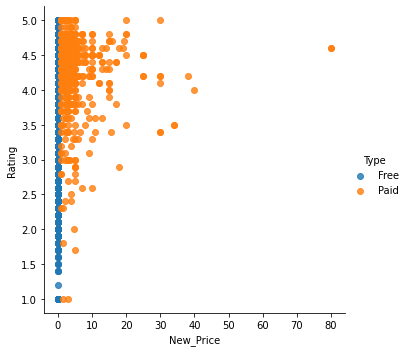

In [27]:
sns.lmplot(x="New_Price",y="Rating",hue='Type',data=my_data,fit_reg=False)

What pattern do you observe? Does rating increase with price?
There is some correlation between price and rating but not very strong. Majority of the paid apps have a higher rating.  

      7.2. Make scatter plot/joinplot for Rating vs. Size

<Figure size 792x576 with 0 Axes>

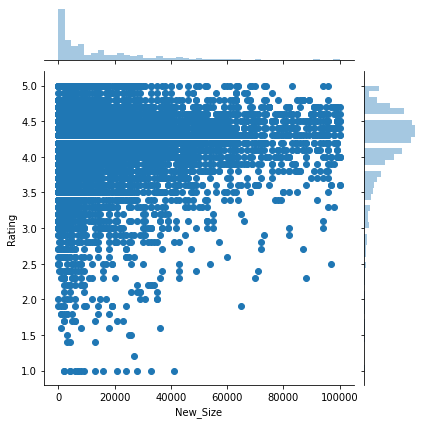

In [28]:
plt.figure(figsize=(11,8))
sns.jointplot(x='New_Size',y='Rating',data=my_data,kind='scatter')

Are heavier apps rated better?
Entries seem evenly distributed throughout sizes. The percentage of large apps having high ratings(>4 and rated better).

     7.3. Make scatter plot/joinplot for Rating vs. Reviews

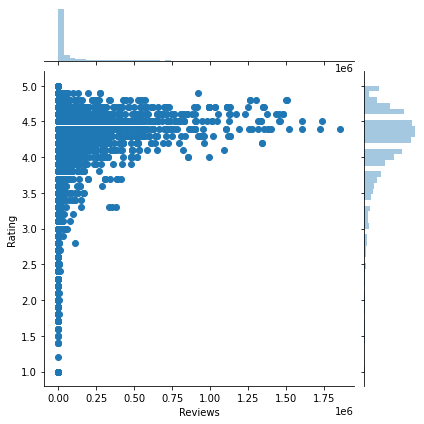

In [29]:
sns.jointplot(x='Reviews',y='Rating',data=my_data,kind='scatter')

Does more review mean a better rating always?
For higher number of reviews, the rating is always greater than 3.5

       7.4.Make boxplot for Rating vs. Content Rating

<AxesSubplot:xlabel='Content Rating', ylabel='Rating'>

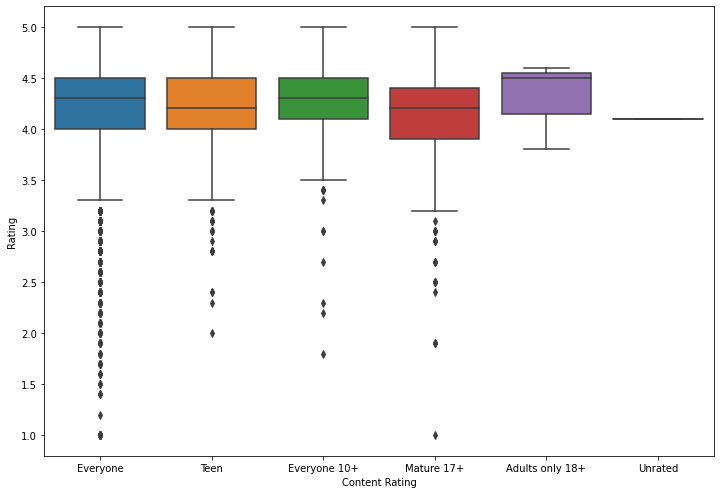

In [30]:
plt.figure(figsize=(12,8.27))
sns.boxplot(x="Content Rating",y="Rating",data=my_data)

Is there any difference in the ratings? Are some types liked better?
No visible changes between categories in relation to ratings.

          7.5. Make boxplot for Ratings vs. Category

Text(0, 0.5, 'Rating')

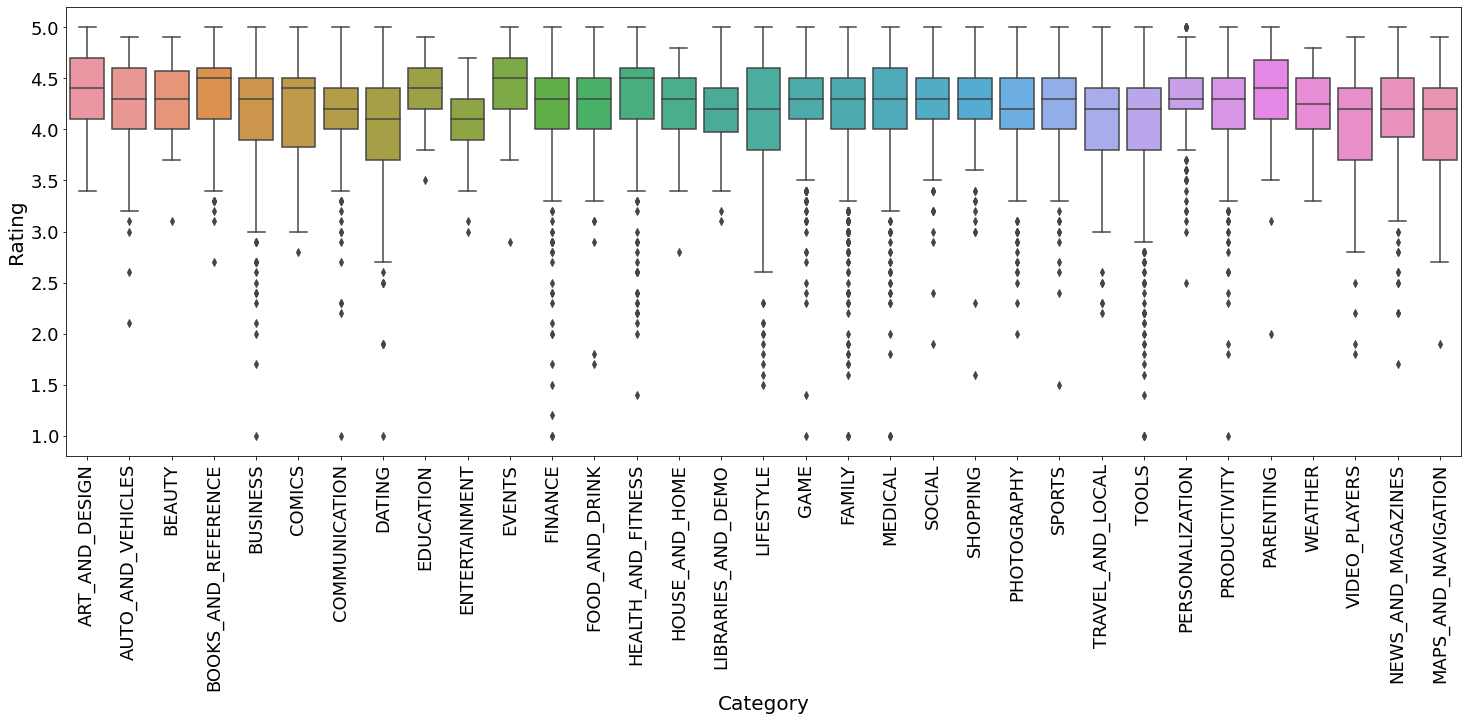

In [31]:
plt.figure(figsize=(25,8.27))
sns.boxplot(my_data.Category,my_data.Rating)
plt.xticks(fontsize=18,rotation='vertical')
plt.yticks(fontsize=18)
plt.xlabel("Category",fontsize=20)
plt.ylabel("Rating",fontsize=20)

Which genre has the best ratings?
 Events

8. Data preprocessing

   - For the steps below, create a copy of the dataframe to make all the edits. Name it inp1.

In [32]:
inp1 = my_data.copy(deep = True)

  - Reviews and Install have some values that are still relatively very high. Before building a linear regression model, you need to reduce the skew. Apply log transformation (np.log1p) to Reviews and Installs.

In [33]:
inp1.Reviews=inp1.Reviews.apply(func=np.log1p)
inp1.New_installs=inp1.New_installs.apply(func=np.log1p)

  - Drop columns App, Last Updated, Current Ver, and Android Ver. These variables are not useful for our task.

In [34]:
inp1.drop(['App','Last Updated','Current Ver','Android Ver','Installs','Price','Size'], axis=1, inplace = True)

   - Get dummy columns for Category, Genres, and Content Rating. This needs to be done as the models do not understand categorical data, and all data should be numeric. Dummy encoding is one way to convert character fields to numeric. Name of dataframe should be inp2.

In [35]:
inp2 = pd.get_dummies(inp1, columns = ['Category','Genres','Content Rating', 'Type'],  drop_first=True)

9. Train test split  and apply 70-30 split. Name the new dataframes df_train and df_test. Separate the dataframes into X_train, y_train, X_test, and y_test.

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as ms

In [37]:
X=inp2.iloc[:,1:].values
y=inp2.iloc[:,:1].values

In [39]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.30, random_state=1)
X_train.shape,X_test.shape

((5947, 156), (2549, 156))

  11 . Model building
  
    • Use linear regression as the technique
    • Report the R2 on the train set


In [40]:
from sklearn.linear_model import LinearRegression
lr=LinearRegression()
model=lr.fit(X_train,y_train)

In [41]:
model.score(X_train, y_train)

0.16739076320835045

  12. Make predictions on test set and report R2.

In [42]:
y_pred= model.predict(X_test)

In [43]:
r2_score(y_test, y_pred)

0.12859034252868462

In our case R2 is very low 0.167 . The R2 should be large enough to explain the strength of the model. If  R2 is low it means  that the dependent  variable is not explained any changes by the independent variables.